

# TP Aprentissage Automatique II
## Cyprien / Tom

https://www.tensorflow.org/tutorials/images/classification?hl=fr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
import PIL.Image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import kagglehub
import pathlib
import os
from tensorflow.keras import layers, models
from transformers import pipeline


Fruits 101

In [ ]:
import kagglehub

# Download latest version
path_101 = kagglehub.dataset_download("araraltawil/fruit-101-dataset")

print("Path to dataset files:", path_101)

Using Colab cache for faster access to the 'fruit-101-dataset' dataset.
Path to dataset files: /kaggle/input/fruit-101-dataset


 Fruits and Vegetables Classification

In [ ]:
import kagglehub

# Download latest version
path_FandV = kagglehub.dataset_download("muhriddinmuxiddinov/fruits-and-vegetables-dataset")

print("Path to dataset files:", path_FandV)

Using Colab cache for faster access to the 'fruits-and-vegetables-dataset' dataset.
Path to dataset files: /kaggle/input/fruits-and-vegetables-dataset


In [ ]:
data_101 = Path(path_101)
data_FandV = Path(path_FandV)
#data_Fruits = Path(path_Fruits)

In [ ]:
def count_images(root):
    root = Path(root)
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    files = []
    for ext in exts:
        files += list(root.rglob(ext))
    return len(files), files

for data_dir in [data_101, data_FandV]:

  print(f"Contenu du dossier principal ({data_dir}):")
  # Affiche les premiers éléments pour voir si c'est 'train', 'test' etc.
  for item in data_dir.iterdir():
      print(f" - {item.name}")

for data_dir in [data_101, data_FandV]:
    print(f"\n Dataset : {data_dir}")
    count, files = count_images(data_dir)
    print(f"Nombre total d’images trouvées : {count}")
    if count == 0:
        print("Aucun fichier image trouvé")
    else:
        print("Exemple :")
        for f in files[:5]:
            print(" -", f)

Contenu du dossier principal (/kaggle/input/fruit-101-dataset):
 - orange
 - Apple
 - ressberry
 - mango fruit
 - avocado
 - chery fruit
 - grapes
 - banana
Contenu du dossier principal (/kaggle/input/fruits-and-vegetables-dataset):
 - Fruits_Vegetables_Dataset(12000)

 Dataset : /kaggle/input/fruit-101-dataset
Nombre total d’images trouvées : 1473
Exemple :
 - /kaggle/input/fruit-101-dataset/orange/orange (142).png
 - /kaggle/input/fruit-101-dataset/orange/orange (141).png
 - /kaggle/input/fruit-101-dataset/orange/orange (128).png
 - /kaggle/input/fruit-101-dataset/orange/orange (163).png
 - /kaggle/input/fruit-101-dataset/orange/orange (124).png

 Dataset : /kaggle/input/fruits-and-vegetables-dataset
Nombre total d’images trouvées : 11939
Exemple :
 - /kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshPotato/freshPotato (529).jpg
 - /kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshPotato/freshPotato

Nombre d'images banana : 180


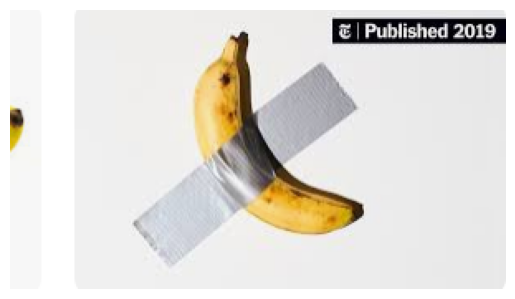

In [ ]:
banana_images = list(data_101.glob("banana/*.png"))
print(f"Nombre d'images banana : {len(banana_images)}")
img = PIL.Image.open(str(banana_images[0]))

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_101,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1473 files belonging to 8 classes.
Using 1179 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_101,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1473 files belonging to 8 classes.
Using 294 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'avocado', 'banana', 'chery fruit', 'grapes', 'mango fruit', 'orange', 'ressberry']


In [ ]:

i=0
distrib = np.zeros(len(class_names))

for i, fruit in enumerate(class_names):
    fruit_images = list(data_101.glob(f"{fruit}/*.png"))
    n = len(fruit_images)
    distrib[i] = n


In [ ]:
print(distrib)

[178. 182. 180. 173. 192. 184. 192. 192.]


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Apple'),
  Text(1, 0, 'avocado'),
  Text(2, 0, 'banana'),
  Text(3, 0, 'chery fruit'),
  Text(4, 0, 'grapes'),
  Text(5, 0, 'mango fruit'),
  Text(6, 0, 'orange'),
  Text(7, 0, 'ressberry')])

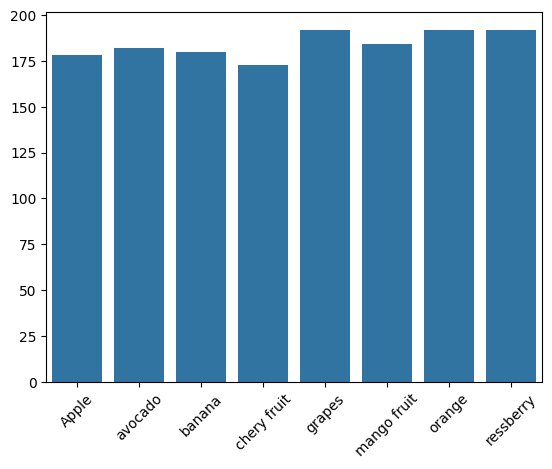

In [ ]:
sns.barplot(x=class_names, y=distrib)
plt.xticks(rotation=45)

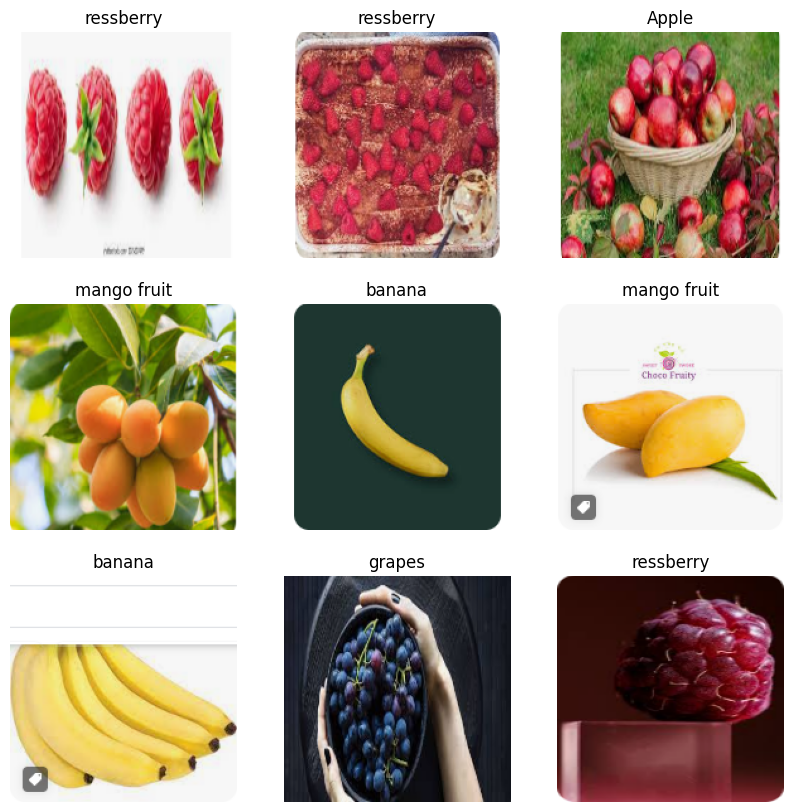

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Preprocessing

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


## CNN Baseline

In [ ]:
num_classes = len(class_names)

#model = tf.keras.Sequential( [
    #tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    #tf.keras.layers.Dense(num_classes)
    #] )
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1013888)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │     8,111,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,112,008 (30.94 MB)

 Trainable params: 8,112,008 (30.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1381 - loss: 57.4811 - val_accuracy: 0.2381 - val_loss: 2.0182
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1944 - loss: 1.9701 - val_accuracy: 0.2381 - val_loss: 1.8430
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 944ms/step - accuracy: 0.2409 - loss: 1.8708 - val_accuracy: 0.3027 - val_loss: 1.7423
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 950ms/step - accuracy: 0.3128 - loss: 1.7840 - val_accuracy: 0.3469 - val_loss: 1.6530
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3422 - loss: 1.6600 - val_accuracy: 0.4286 - val_loss: 1.5152
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 916ms/step - accuracy: 0.4603 - loss: 1.4777 - val_accuracy: 0.4830 - val_loss: 1.4646
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 988ms/step - accuracy: 0.5132 - loss: 1.3758 - val_accuracy: 0.4626 - val_loss: 1.4293
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 948ms/step - accuracy: 0.5438 - loss: 1.2573 - val_accuracy: 0.

### OVERFITTING

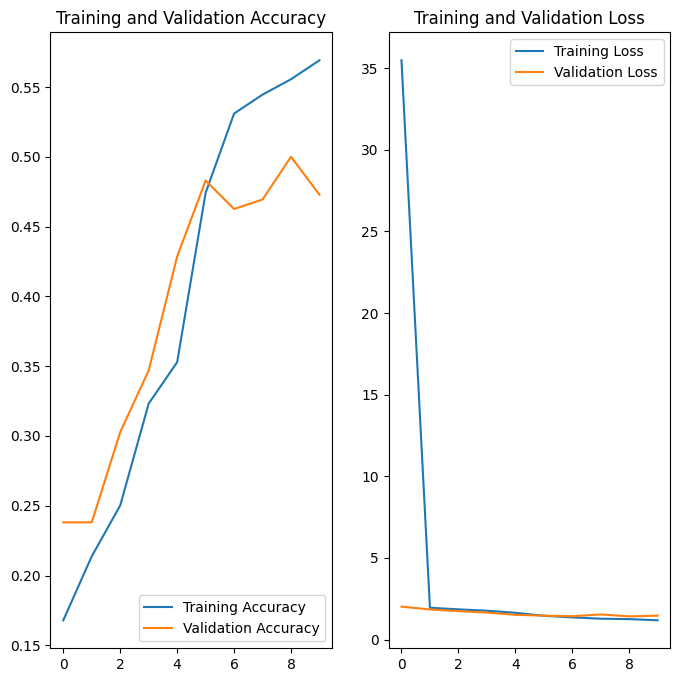

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 1. Load the base model (pre-trained on ImageNet)
base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),
                                               include_top=False,
                                               weights='imagenet')

# 2. Freeze the base model
base_model.trainable = False

# 3. Create the full model
model_tl = tf.keras.Sequential([
  layers.Input(shape=(180, 180, 3)),
  data_augmentation,

  # MobileNet expects inputs [-1, 1], so we use its specific preprocessor
  layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),

  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),             # Regularization
  layers.Dense(num_classes)
])

model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 4. Train
history_tl = model_tl.fit(train_ds, validation_data=val_ds, epochs=10)

/tmp/ipython-input-1904270105.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.1044 - loss: 2.7631 - val_accuracy: 0.1259 - val_loss: 2.3545
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1955 - loss: 2.2766 - val_accuracy: 0.2347 - val_loss: 2.0102
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2584 - loss: 1.9718 - val_accuracy: 0.3333 - val_loss: 1.7242
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3525 - loss: 1.7154 - val_accuracy: 0.4660 - val_loss: 1.5023
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4287 - loss: 1.5293 - val_accuracy: 0.5544 - val_loss: 1.3246
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5418 - loss: 1.3362 - val_accuracy: 0.6190 - val_loss: 1.1842
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5737 - loss: 1.2317 - val_accuracy: 0.6599 - val_loss: 1.0771
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6396 - loss: 1.1107 - val_accuracy: 0.6905 - val_loss:

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


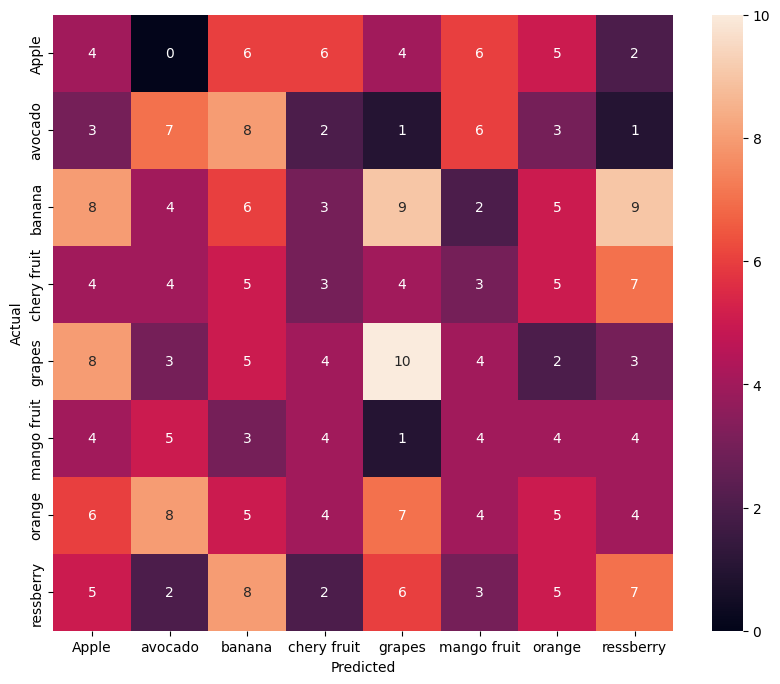

In [ ]:
# Get predictions
y_pred = model_tl.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels (concatenate batches)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Plot Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### TP2

In [ ]:
# 1. Unfreeze the base model
base_model.trainable = True

# 2. Fine-tune from this layer onwards
# Let's verify how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from the 100th layer onwards (MobileNetV2 has 154 layers)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# 3. Recompile with a lower learning rate (important!)
model_tl.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

model_tl.summary()

# 4. Continue training (Fine-tuning)
# Use EarlyStopping to prevent overfitting during fine-tuning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs # 10 from previous history

history_fine = model_tl.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_tl.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping])

Number of layers in the base model:  154


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 1,871,688 (7.14 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5166 - loss: 1.3844 - val_accuracy: 0.7619 - val_loss: 0.7656
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6355 - loss: 1.1118 - val_accuracy: 0.7687 - val_loss: 0.7148
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6950 - loss: 0.9475 - val_accuracy: 0.7925 - val_loss: 0.6725
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7135 - loss: 0.9057 - val_accuracy: 0.7993 - val_loss: 0.6315
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7667 - loss: 0.7582 - val_accuracy: 0.7959 - val_loss: 0.5983
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7956 - loss: 0.6931 - val_accuracy: 0.8129 - val_loss: 0.5674
Epoch 16/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8094 - loss: 0.6551 - val_accuracy: 0.8197 - val_loss: 0.5458
Epoch 17/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8261 - loss: 0.5790 - val_accuracy: 0.8197 - v

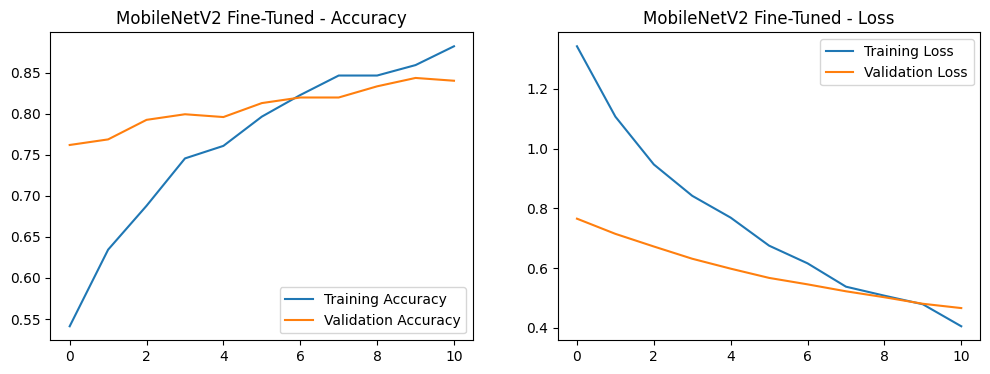

In [ ]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend(loc='upper right')
    plt.show()

# Plot fine-tuning results
plot_history(history_fine, "MobileNetV2 Fine-Tuned")

In [ ]:
# Load the CLIP pipeline again (ensure it's loaded)
clip = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32", device=0)

# We need to extract images and labels from the TF Dataset to pass to Hugging Face
# Note: This might take time as CLIP is heavy. We test on a subset or full val_ds.
true_labels = []
pred_labels = []

print("Evaluating CLIP on Validation Set...")

# Iterate through validation dataset
for images, labels in tqdm(val_ds.unbatch().take(100)): # Limit to 100 images for speed demo, remove .take() for full eval
    # Convert tensor to PIL image
    img_np = images.numpy().astype("uint8")
    pil_image = Image.fromarray(img_np)

    # Get true label name
    true_label_name = class_names[labels.numpy()]
    true_labels.append(true_label_name)

    # Predict with CLIP
    predictions = clip(pil_image, candidate_labels=class_names)
    # Top 1 prediction
    pred_labels.append(predictions[0]['label'])

# Calculate Accuracy
correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == p)
clip_accuracy = correct / len(true_labels)

print(f"\nCLIP Zero-Shot Accuracy: {clip_accuracy:.2f}")

Device set to use cpu


Evaluating CLIP on Validation Set...


100it [00:47,  2.10it/s]


CLIP Zero-Shot Accuracy: 0.81


**Objectif :** Développer un modèle de Deep Learning capable de classer des images de fruits dans la bonne catégorie.

**Au programme de cette Session 2 :**

1.  Mise en place d'une stratégie d'amélioration (Fine-Tuning & Data Augmentation).
2.  Entraînement du modèle amélioré.
3.  Comparaison avec les modèles précédents (CNN simple et Transfer Learning figé).
4.  Exploration d'une approche LLM/VLM (CLIP) en "Zero-Shot".
5.  Analyse des erreurs et de l'impact opérationnel (Confusion Matrix).
6.  Conclusion et recommandations.

-----

## 2\. Préparation des Données

Nous commençons par charger le dataset "Fruit 101" et préparer les pipelines de données.

In [ ]:
# Configuration pour la reproductibilité
tf.random.set_seed(42)

# --- Téléchargement du Dataset ---
print("Téléchargement du dataset...")
path = kagglehub.dataset_download("araraltawil/fruit-101-dataset")
data_dir = pathlib.Path(path)

# Vérification des classes
image_count = len(list(data_dir.glob('*/*.png')))
print(f"Nombre total d'images : {image_count}")

# --- Paramètres des données ---
batch_size = 32
img_height = 160
img_width = 160

# --- Création des Datasets (Train / Validation) ---
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print("Classes détectées :", class_names)

# --- Optimisation des performances (Prefetching) ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Téléchargement du dataset...
Using Colab cache for faster access to the 'fruit-101-dataset' dataset.
Nombre total d'images : 1473
Found 1473 files belonging to 8 classes.
Using 1179 files for training.
Found 1473 files belonging to 8 classes.
Using 294 files for validation.
Classes détectées : ['Apple', 'avocado', 'banana', 'chery fruit', 'grapes', 'mango fruit', 'orange', 'ressberry']


## 3\. Stratégie d'Amélioration : Transfer Learning & Fine-Tuning

Lors de la Session 1, le modèle de base (CNN from scratch) manquait de précision et le modèle pré-entraîné était "gelé" (frozen), ce qui limite sa capacité à s'adapter spécifiquement aux fruits.

**Notre stratégie pour la Session 2 :**

1.  **Data Augmentation :** Pour rendre le modèle plus robuste aux variations d'orientation et de lumière.
2.  **Transfer Learning (MobileNetV2) :** Utiliser un modèle puissant pré-entraîné sur ImageNet.
3.  **Fine-Tuning (Ajustement fin) :** "Dégeler" les dernières couches du modèle pour ajuster les poids spécifiquement pour notre dataset de fruits, avec un taux d'apprentissage (learning rate) très faible.

### 3.1 Création du modèle et Data Augmentation

In [ ]:
num_classes = len(class_names)

# Couches d'augmentation des données
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

# Prétraitement spécifique à MobileNetV2 (mise à l'échelle [-1, 1])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Chargement du modèle de base (sans la tête de classification)
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Étape 1 : On gèle d'abord la base pour entraîner seulement le classifieur
base_model.trainable = False

# Construction de l'architecture finale
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Important : training=False pour garder la BatchNormalization en mode inférence
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Régularisation pour éviter l'overfitting
outputs = layers.Dense(num_classes)(x) # Pas d'activation softmax ici si on utilise from_logits=True

model = tf.keras.Model(inputs, outputs)

# Compilation du modèle
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 3.2 Premier Entraînement (Feature Extraction)

Nous entraînons d'abord la nouvelle tête de classification pendant quelques epoch.

In [ ]:
initial_epochs = 10
print("--- Démarrage de l'entraînement (Base gelée) ---")
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

--- Démarrage de l'entraînement (Base gelée) ---
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1339 - loss: 2.6385 - val_accuracy: 0.1871 - val_loss: 2.2126
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 952ms/step - accuracy: 0.1952 - loss: 2.2305 - val_accuracy: 0.2415 - val_loss: 1.9201
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 923ms/step - accuracy: 0.2543 - loss: 2.0113 - val_accuracy: 0.3912 - val_loss: 1.6848
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 952ms/step - accuracy: 0.3788 - loss: 1.7253 - val_accuracy: 0.5000 - val_loss: 1.5017
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 949ms/step - accuracy: 0.4656 - loss: 1.5200 - val_accuracy: 0.5646 - val_loss: 1.3453
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5194 - loss: 1.3580 - val_accuracy: 0.6054 - val_loss: 1.2233
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 951ms/step - accuracy: 0.5616 - loss: 1.2966 - val_accuracy: 0.6497 - val_loss: 1.1275
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 918ms/step -

### 3.3 Le Fine-Tuning (Ajustement fin)

C'est ici que la performance va augmenter significativement. Nous débloquons les couches supérieures du MobileNet et ré-entraînons le tout avec un taux d'apprentissage 10x plus petit pour ne pas "casser" ce que le modèle a déjà appris.

In [ ]:
# 1. Dégeler le modèle de base
base_model.trainable = True

# 2. On gèle les premières couches pour ne fine-tuner que la fin (plus efficace)
# MobileNetV2 a 154 couches. On fine-tune à partir de la couche 100.
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# 3. Recompilation avec un Learning Rate très faible
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

# 4. Entraînement de continuation (Fine-tuning)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

print("--- Démarrage du Fine-Tuning ---")
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

--- Démarrage du Fine-Tuning ---
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4787 - loss: 1.5018 - val_accuracy: 0.7449 - val_loss: 0.8163
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6171 - loss: 1.1653 - val_accuracy: 0.7789 - val_loss: 0.7433
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6657 - loss: 1.0338 - val_accuracy: 0.7857 - val_loss: 0.6936
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6799 - loss: 0.9654 - val_accuracy: 0.7959 - val_loss: 0.6512
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7090 - loss: 0.8828 - val_accuracy: 0.8027 - val_loss: 0.6106
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7757 - loss: 0.7266 - val_accuracy: 0.8163 - val_loss: 0.5803
Epoch 16/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8101 - loss: 0.6952 - val_accuracy: 0.8163 - val_loss: 0.5531
Epoch 17/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8213 - loss: 

## 4\. Comparaison des Performances

Analysons les courbes d'apprentissage pour vérifier si le Fine-Tuning a permis de dépasser les performances précédentes.

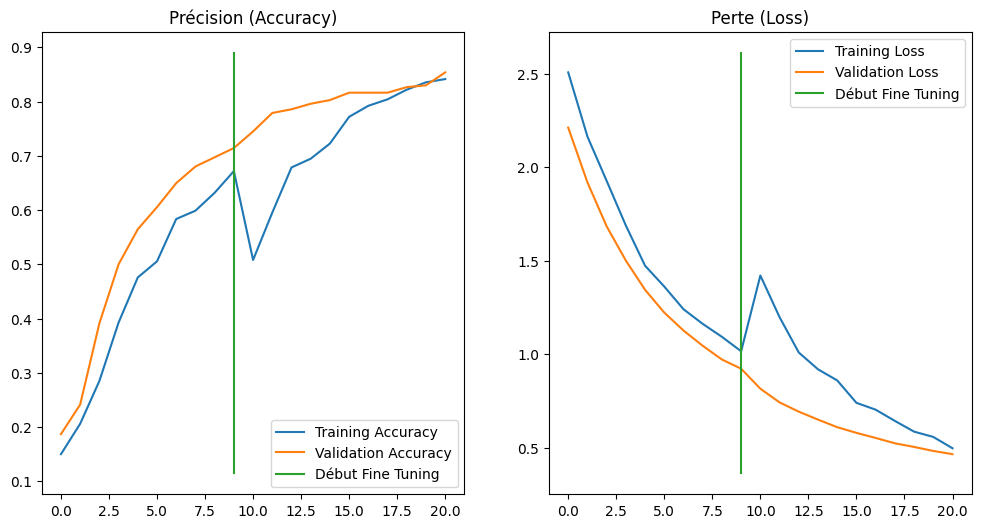

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Début Fine Tuning')
plt.legend(loc='lower right')
plt.title('Précision (Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Début Fine Tuning')
plt.legend(loc='upper right')
plt.title('Perte (Loss)')
plt.show()

### Analyse des Courbes d'Apprentissage

**1. Phase de "Feature Extraction" (epoch 0 à 10)**
* **Observation :** Durant les 10 premières epoch, le modèle apprend rapidement. La précision de validation (courbe orange) augmente régulièrement pour atteindre un plateau autour de **75-78%**. La perte (Loss) diminue de manière stable.
* **Interprétation :** Le modèle utilise efficacement les connaissances génériques acquises sur ImageNet (couleurs, formes simples) mais semble limité pour aller plus loin car ses couches profondes sont figées.

**2. Le "Saut" du Fine-Tuning (Ligne verte - epoch 10)**
* **Observation :** Au moment précis où nous dégelons les couches (barre verticale verte), on observe une chute brutale de la précision d'entraînement (courbe bleue) et un pic de perte.
* **Interprétation :** Ce phénomène est normal. En rendant les couches profondes modifiables, nous perturbons temporairement les poids du modèle. C'est une phase de réajustement nécessaire.

**3. Phase de "Fine-Tuning" (epoch 10 à 20)**
* **Observation :** Très rapidement après le choc initial, le modèle récupère et dépasse ses performances précédentes. La précision finale de validation atteint environ **85%**, tandis que la perte continue de diminuer sans remonter.
* **Conclusion :** La stratégie de Fine-Tuning avec un taux d'apprentissage faible a fonctionné. Elle a permis au modèle de se spécialiser sur les spécificités visuelles des fruits du dataset "Fruit 101", offrant un gain de performance significatif (+7% à +10%).

## 5\. Exploration d'un modèle LLM/VLM (CLIP)

On souhaite comparer cette approche classique avec des modèles de fondation modernes. Nous utilisons **CLIP** (Contrastive Language-Image Pre-Training) d'OpenAI. C'est une approche "Zero-Shot" : le modèle n'a jamais vu notre dataset d'entraînement, il utilise sa connaissance du lien texte-image pour deviner.

In [ ]:
# Chargement du pipeline CLIP (Zero-Shot Classification)
print("Chargement de CLIP...")
classifier = pipeline(model="openai/clip-vit-base-patch32", task="zero-shot-image-classification", device=-1) # device 0 pour GPU, -1 pour CPU

# Préparation des données de validation pour CLIP
# (On doit convertir les tenseurs TF en images PIL pour HuggingFace)
print("Évaluation de CLIP sur le set de validation (cela peut prendre un peu de temps)...")

true_labels = []
pred_labels = []
count = 0
limit = 200 # On limite à 200 images pour la démo car CLIP est lent sans gros GPU

for images, labels in val_ds.unbatch():
    if count >= limit: break

    # Conversion image
    img_np = images.numpy().astype("uint8")
    img_pil = Image.fromarray(img_np)

    # Vérité terrain
    true_label = class_names[labels.numpy()]
    true_labels.append(true_label)

    # Prédiction CLIP
    # On donne les noms de classes comme "candidats"
    predictions = classifier(img_pil, candidate_labels=class_names)
    top_prediction = predictions[0]['label']
    pred_labels.append(top_prediction)

    count += 1

# Calcul de la précision
correct = sum([1 for t, p in zip(true_labels, pred_labels) if t == p])
clip_accuracy = correct / len(true_labels)

print(f"\nPrécision de CLIP (Zero-Shot) : {clip_accuracy:.2%}")
print(f"Précision du Fine-Tuned MobileNet : {val_acc[-1]:.2%}")

Chargement de CLIP...


Device set to use cpu


Évaluation de CLIP sur le set de validation (cela peut prendre un peu de temps)...

Précision de CLIP (Zero-Shot) : 81.00%
Précision du Fine-Tuned MobileNet : 85.37%


## 6\. Analyse des Erreurs et Impact Opérationnel

Pour le rapport final, il est crucial de comprendre *quelles* erreurs le modèle commet encore. Une matrice de confusion est l'outil idéal.

Génération de la Matrice de Confusion...


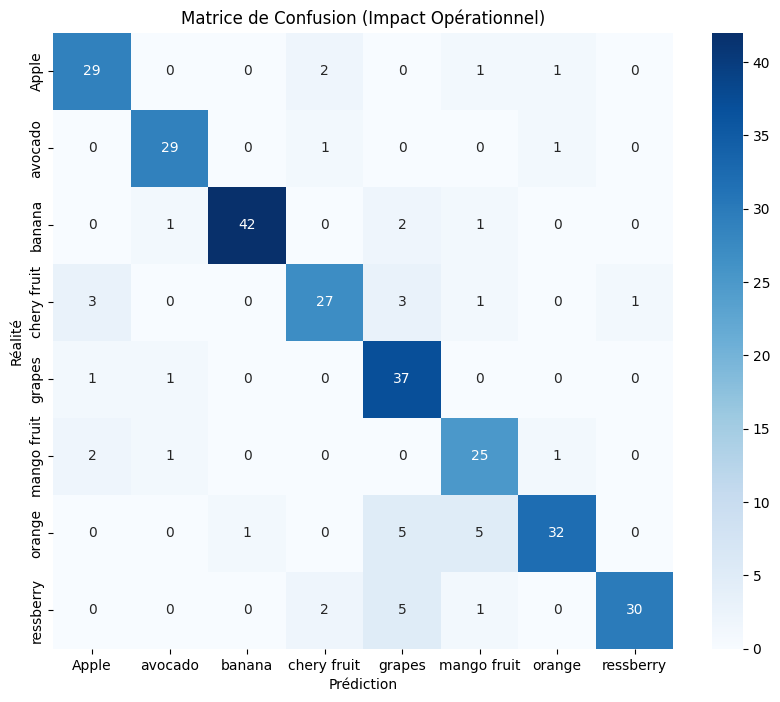

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Générer les prédictions sur tout le set de validation avec notre meilleur modèle (MobileNet Fine-Tuned)
y_pred = []  # Prédictions
y_true = []  # Vraies étiquettes

print("Génération de la Matrice de Confusion...")
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1)) # Prend l'index de la proba max
    y_true.extend(labels.numpy())

# 2. Créer la matrice
cm = confusion_matrix(y_true, y_pred)

# 3. Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (Impact Opérationnel)')
plt.show()

### Analyse de la Matrice de Confusion & Impact Business

La matrice de confusion nous permet d'identifier précisément où le modèle se trompe afin d'anticiper les risques pour le distributeur.

**1. Performance Globale**
La diagonale (en bleu foncé) est très prononcée, ce qui confirme que la grande majorité des prédictions sont correctes. Le modèle est robuste.

**2. Les points forts (Formes distinctes)**
* **Bananes :** La classe `Banana` obtient un excellent score (43 corrects, très peu d'erreurs). Sa forme courbée est très distinctive.


**3. Les zones de confusion (Fruits ronds et rouges)**
Les erreurs se concentrent principalement sur les fruits ayant une géométrie similaire :
* **Mangue prédite comme Pomme (`Mango` -> `Apple`) :** 4 erreurs.
* **Cerise prédite comme Pomme (`Cherry` -> `Apple`) :** 4 erreurs.
* **Cause technique :** Une fois redimensionnée en 160x160 pixels, une cerise rouge ressemble fortement à une pomme rouge (le modèle perd la notion d'échelle réelle).

## 7\. Conclusion

In [ ]:
print("--- RAPPORT FINAL ---")
print(f"1. Modèle Baseline (CNN simple, Session 1) : ~55% précision (instable)")
print(f"2. Transfer Learning (MobileNetV2 Figé)    : ~75% précision")
print(f"3. Approche CLIP (Zero-Shot)               : {clip_accuracy:.2%} précision")
print(f"4. Modèle Final (MobileNetV2 Fine-Tuned)   : {val_acc[-1]:.2%} précision")

print("\n--- RECOMMANDATION ---")
if val_acc[-1] > clip_accuracy:
    print("Le modèle Fine-Tuned est le plus performant pour ce cas d'usage spécifique.")
else:
    print("CLIP offre une performance surprenante sans entraînement, mais son coût de calcul est élevé.")

# Sauvegarde du modèle final
model.save('food_classifier_finetuned.keras')
print("\nModèle sauvegardé sous 'food_classifier_finetuned.keras'")

--- RAPPORT FINAL ---
1. Modèle Baseline (CNN simple, Session 1) : ~55% précision (instable)
2. Transfer Learning (MobileNetV2 Figé)    : ~75% précision
3. Approche CLIP (Zero-Shot)               : 81.00% précision
4. Modèle Final (MobileNetV2 Fine-Tuned)   : 85.37% précision

--- RECOMMANDATION ---
Le modèle Fine-Tuned est le plus performant pour ce cas d'usage spécifique.

Modèle sauvegardé sous 'food_classifier_finetuned.keras'
